<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Labwork-1.2.-Finding-answers-to-analytical-questions-with-SQL-for-data-stored-in-ClickHouse" data-toc-modified-id="Labwork-1.2.-Finding-answers-to-analytical-questions-with-SQL-for-data-stored-in-ClickHouse-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Labwork 1.2. Finding answers to analytical questions with SQL for data stored in ClickHouse</a></span></li><li><span><a href="#ClickHouse:-how-to-access-from-JupyterHub" data-toc-modified-id="ClickHouse:-how-to-access-from-JupyterHub-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>ClickHouse: how to access from JupyterHub</a></span><ul class="toc-item"><li><span><a href="#Import-libraries-and-set-access-parameters" data-toc-modified-id="Import-libraries-and-set-access-parameters-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Import libraries and set access parameters</a></span></li><li><span><a href="#How-to-access" data-toc-modified-id="How-to-access-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>How to access</a></span></li><li><span><a href="#Example-queries" data-toc-modified-id="Example-queries-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Example queries</a></span></li></ul></li><li><span><a href="#Self-control-stops" data-toc-modified-id="Self-control-stops-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Self-control stops</a></span></li></ul></div>

# Labwork 1.2. Finding answers to analytical questions with SQL for data stored in ClickHouse
In this lab we'll try ourselves in the typical analytical environment when answers to our questions are not yet in BI reports and dashboard, but are already presented in analytical database. One of the most popular databases for analytical purposes is ClickHouse, which is the main storage behind Yandex Metrika.

# ClickHouse: how to access from JupyterHub

[ClickHouse®](https://clickhouse.tech/) is a fast open-source OLAP database management system. It is column-oriented and allows to generate analytical reports using SQL queries in real-time.

We have a local installation of ClickHouse database that collects logs from [GSOM site](https://gsom.spbu.ru/) and is available in read-only format for you to learn how to use ClickHouse in your tasks.

## Import libraries and set access parameters

In [1]:
import os
import json
import requests
import pandas as pd
pd.set_option('display.max_columns', None)

Set host and port to get to database. ClickHouse has no external IP address, so it is available only from JupyterHub notebooks:

In [2]:
# CH_HOST = 'http://10.129.0.30'
CH_HOST = 'http://51.250.107.52'
CH_PORT = '8123'
SSL_VERIFY = True

## How to access

Our main function for access to ClickHouse will take parameters like database host, username, password, query and will returd data from database:

In [3]:
def get_data(query, host, user_name, user_passwd):
    if (user_name == '') and (user_passwd == ''):
        r = requests.post(host, params=query_dict, verify=SSL_VERIFY)
    else:
        r = requests.post(host, data=query,
                          auth=(user_name, user_passwd), verify=SSL_VERIFY)
    print('request status code:', r.status_code)
    return r.text

In [4]:
CLICKHOUSE_USER = os.environ['CLICKHOUSE_USER']
CLICKHOUSE_PASSWORD = os.environ['CLICKHOUSE_PASSWORD']

In [5]:
def get_data_short(query):
    return get_data(query=query, 
                host=':'.join([CH_HOST, CH_PORT]),
                user_name=CLICKHOUSE_USER,
                user_passwd=CLICKHOUSE_PASSWORD)


ClickHouse uses [SQL syntax](https://clickhouse.tech/docs/en/sql-reference/syntax/) for its queries, so let's define our first query:

In [6]:
query = 'SHOW DATABASES'

...and put it to function:

In [7]:
data = get_data_short(query)

request status code: 200


__NOTE:__ Username (or login) and password are stored in environment variables `CLICKHOUSE_USER`, `CLICKHOUSE_PASSWORD` for safety and are available through `os` library as `os.environ['<ENV_VARIABLE_NAME>']`.

The data from database is returnes as string, so postprocessing is needed:

In [8]:
data = [x.split('\t') for x in data.split('\n')]
pd.DataFrame(data)

,0
0,gsomlogs
1,


In [9]:
print(data)

[['gsomlogs'], ['']]


## Example queries

Now we know what databases are in ClickHouse. Build a more complicated query to obtain names of all tables in database:

In [10]:
query = 'SHOW TABLES FROM gsomlogs'

In [11]:
data = get_data_short(query)
data = [x.split('\t') for x in data.split('\n')]
pd.DataFrame(data)

request status code: 200


,0
0,hits_all
1,visits_all
2,


Let's get fields of selected table:

In [12]:
query = 'SHOW CREATE TABLE gsomlogs.hits_all'

In [13]:
query = 'show create table gsomlogs.hits_all'
data = get_data_short(query=query)
print()
for x in data.split('\\n'):
    print(x)
    
# documentation for the fields can be found here: https://yandex.com/dev/metrika/doc/api2/logs/fields/hits.html

request status code: 200

CREATE TABLE gsomlogs.hits_all
(
    `Artificial` UInt8,
    `Browser` String,
    `BrowserCountry` String,
    `BrowserEngine` String,
    `BrowserEngineVersion1` UInt16,
    `BrowserEngineVersion2` UInt16,
    `BrowserEngineVersion3` UInt16,
    `BrowserEngineVersion4` UInt16,
    `BrowserLanguage` String,
    `BrowserMajorVersion` UInt16,
    `BrowserMinorVersion` UInt16,
    `ClientID` UInt64,
    `ClientTimeZone` Int16,
    `CookieEnabled` UInt8,
    `CounterID` UInt32,
    `Date` Date,
    `DateTime` DateTime,
    `DeviceCategory` String,
    `Download` UInt8,
    `From` String,
    `GCLID` String,
    `GoalsID` Array(UInt32),
    `HasGCLID` UInt8,
    `HttpError` String,
    `IFrame` UInt8,
    `IpAddress` String,
    `IsPageView` UInt8,
    `JavascriptEnabled` UInt8,
    `LastAdvEngine` String,
    `LastSearchEngine` String,
    `LastSearchEngineRoot` String,
    `LastSocialNetwork` String,
    `LastSocialNetworkProfile` String,
    `LastTrafficSource`

In [14]:
print(type(data))

<class 'str'>


Now we are ready to deep dive into data in tables (but for the demo will limit our query for the first 5 rows):

In [15]:
query = 'SELECT * FROM gsomlogs.visits_all ORDER BY DateTime DESC LIMIT 5'
# documentation for the fields can be found here: https://yandex.com/dev/metrika/doc/api2/logs/fields/visits.html    

In [16]:
#we get all the lines using \n
data = get_data_short(query=query)
data = [x.split('\t') for x in data.split('\n')]
df = pd.DataFrame(data)
df.head()

request status code: 200


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130
0,1,safari_mobile,,WebKit,605,1,15,0,ru,15,2,16643478951044796309,180,1,211680,2022-10-01,2022-10-01 23:57:08,2022-10-01 23:57:08,2,https://gsom.spbu.ru/gsom/career/consulting/pr...,,,[],[],[],[],[],[],0,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],2606:54c0:61a0:28::xxx,1,1,ya_undefined,,,0,0,0,,0,,,,,,google.ru,google_search,google,,,,organic,apple,iPhone,,[],[],[],[],[],[],,,,,ios15,ios_double,1,2436,1126,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],https://google.ru/,Saint Petersburg,2,Russia,225,32,9:21,812,1,375,https://gsom.spbu.ru/gsom/career/consulting/pr...,,,,,,0,5772680408547459351,[5772680408547459351],628,375
1,0,yandex_browser,,WebKit,537,36,0,0,ru,22,9,1565872659818418236,180,1,211680,2022-10-01,2022-10-01 23:55:52,2022-10-01 23:55:52,1,https://gsom.spbu.ru/events/event2022-10-13/,,,[],[],[],[],[],[],0,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],188.242.40.xxx,0,1,ya_undefined,,,0,0,0,,0,,,,,,yandex.ru,yandex_search,yandex,,,,organic,,,,[],[],[],[],[],[],,,,,windows10,windows,2,720,1280,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],https://yandex.ru/,Saint Petersburg,2,Russia,225,24,16:9,720,2,1280,https://gsom.spbu.ru/,,,,,,4,5772660443029700842,"[5772660443029700842,5772661083222835434,57726...",605,1263
2,0,safari_mobile,,WebKit,605,1,15,0,ru,16,0,166465757434838070,180,1,211680,2022-10-01,2022-10-01 23:52:54,2022-10-01 23:52:54,2,https://gsom.spbu.ru/students/blog/blog2020-12...,,,[],[],[],[],[],[],0,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],2606:54c0:61c0:28::xxx,1,1,ya_undefined,,,0,0,0,,0,,,,,,google.ru,google_search,google,,,,organic,apple,iPhone,,[],[],[],[],[],[],,,,,ios16,ios_double,1,2532,1170,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],https://google.ru/,Saint Petersburg,2,Russia,225,32,9:21,844,1,390,https://gsom.spbu.ru/students/blog/blog2020-12...,,,,,,516,5772613885818306667,"[5772613885818306667,5772617057612595380,57727...",664,390
3,1,chrome,ru,WebKit,537,36,0,0,ru,106,0,1652005834609769546,180,1,211680,2022-10-01,2022-10-01 23:51:27,2022-10-01 23:51:27,1,https://gsom.spbu.ru/gsom/library/index/greben...,,,[],[],[],[],[],[],0,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],195.19.228.xxx,0,1,ya_undefined,,,0,0,0,,0,,,,,,,,,,,,direct,,,,[],[],[],[],[],[],,,,,windows10,windows,1,720,1280,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],,,0,Russia,225,24,16:9,720,2,1280,https://gsom.spbu.ru/gsom/library/index/greben...,,,,,,6,5772591087310340109,"[5772591087310340109,5772592555431297037,57725...",759,1684
4,0,edge,,WebKit,537,36,0,0,ru,105,0,1624345633121255620,180,1,211680,2022-10-01,2022-10-01 23:50:53,2022-10-01 23:50:53,1,https://gsom.spbu.ru/gsom/library/dspace/,,,[],[],[],[],[],[],0,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],5.18.90.xxx,1,1,ya_undefined,,,0,0,0,,0,,,,,,google.com,google_search,google,,,,organic,,,,[],[],[],[],[],[],,,,,windows10,windows,2,1080,1920,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],https://google.com/,Saint Petersburg,2,Russia,225,24,16:9,864,2,1536,https://gsom.spbu.ru/gsom/library/dspace/,,,,,,562,5772582104576557269,"[5772582104576557269,5772587777597636653,57725...",753,1518


In [17]:
query = "SELECT * FROM gsomlogs.hits_all ORDER BY DateTime DESC LIMIT 10"

In [18]:
data = get_data_short(query=query)
data = [x.split('\t') for x in data.split('\n')]
df = pd.DataFrame(data)
df.head(10)

request status code: 200


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
0,0,edge,,WebKit,537,36,0,0,ru,105,0,1624345633121255620,180,1,211680,2022-10-01,2022-10-01 23:59:58,1,0,,,[],0,0,0,5.18.90.xxx,1,1,,google_search,google,,,organic,0,,,,0,,,,,windows10,windows,utf-8,1080,1920,https://google.com/,Saint Petersburg,2,Russia,225,24,16:9,864,2,1536,,,,Институциональный pепозиторий открытого доступ...,https://gsom.spbu.ru/gsom/library/dspace/,,,,,,5772724954149683201,753,1518
1,0,safari_mobile,,WebKit,605,1,15,0,ru,15,2,16643478951044796309,180,1,211680,2022-10-01,2022-10-01 23:57:08,2,0,,,[],0,0,0,2606:54c0:61a0:28::xxx,1,1,,google_search,google,,,organic,0,apple,iPhone,,0,,,,,ios15,ios_double,utf-8,2436,1126,https://google.ru/,Saint Petersburg,2,Russia,225,32,9:21,812,1,375,,,,Консультационные проекты,https://gsom.spbu.ru/gsom/career/consulting/pr...,,,,,,5772680408547459351,628,375
2,0,yandex_browser,,WebKit,537,36,0,0,ru,22,9,1565872659818418236,180,1,211680,2022-10-01,2022-10-01 23:55:56,1,0,,,[],0,0,0,188.242.40.xxx,1,1,,,,,,internal,0,,,,0,,,,,windows10,windows,utf-8,720,1280,https://gsom.spbu.ru/,Saint Petersburg,2,Russia,225,24,16:9,720,2,1280,,,,Цикл тренингов по публичным выступлениям,https://gsom.spbu.ru/events/event2022-10-13/,,,,,,5772661582364672266,605,1263
3,0,yandex_browser,,WebKit,537,36,0,0,ru,22,9,1565872659818418236,180,1,211680,2022-10-01,2022-10-01 23:55:52,1,0,,,[],0,0,0,188.242.40.xxx,1,1,,yandex_search,yandex,,,organic,0,,,,0,,,,,windows10,windows,utf-8,720,1280,https://yandex.ru/,Saint Petersburg,2,Russia,225,24,16:9,720,2,1280,,,,Высшая школа менеджмента СПбГУ — ведущая росси...,https://gsom.spbu.ru/,,,,,,5772660443029700842,605,1263
4,0,safari_mobile,,WebKit,605,1,15,0,ru,16,0,166465757434838070,180,1,211680,2022-10-01,2022-10-01 23:52:54,2,0,,,[],0,0,0,2606:54c0:61c0:28::xxx,1,1,,google_search,google,,,organic,0,apple,iPhone,,0,,,,,ios16,ios_double,utf-8,2532,1170,https://google.ru/,Saint Petersburg,2,Russia,225,32,9:21,844,1,390,,,,"Как найти работу в Южной Корее, не зная корейс...",https://gsom.spbu.ru/students/blog/blog2020-12...,,,,,,5772613885818306667,664,390
5,0,chrome,ru,WebKit,537,36,0,0,ru,106,0,1652005834609769546,180,1,211680,2022-10-01,2022-10-01 23:51:33,1,0,,,[],0,0,0,195.19.228.xxx,0,1,,,,,,external,1,,,,0,,,,,windows10,windows,utf-8,720,1280,https://gsom.spbu.ru/gsom/library/index/greben...,,0,Russia,225,24,16:9,720,2,1280,,,,Электронная библиотека ИД Гребенникова,http://cufts.library.spbu.ru/CRDB/SPBGU/resour...,,,,,,5772592555431297037,759,1684
6,0,chrome,ru,WebKit,537,36,0,0,ru,106,0,1652005834609769546,180,1,211680,2022-10-01,2022-10-01 23:51:27,1,0,,,[],0,0,0,195.19.228.xxx,1,1,,,,,,direct,0,,,,0,,,,,windows10,windows,utf-8,720,1280,,,0,Russia,225,24,16:9,720,2,1280,,,,Электронная библиотека ИД Гребенникова,https://gsom.spbu.ru/gsom/library/index/greben...,,,,,,5772591087310340109,759,1684
7,0,edge,,WebKit,537,36,0,0,ru,105,0,1624345633121255620,180,1,211680,2022-10-01,2022-10-01 23:51:14,1,0,,,[],0,0,0,5.18.90.xxx,0,1,,,,,,external,1,,,,0,,,,,windows10,windows,utf-8,1080,1920,https://gsom.spbu.ru/gsom/library/dspace/,Saint Petersburg,2,Russia,225,24,16:9,864,2,1536,,,,Институциональный pепозиторий открытого доступ...,https://diploma.spbu.ru/gp,,,,,,5772587777597636653,753,1518
8,0,edge,,WebKit,537,36,0,0,ru,105,0,1624345633121255620,180,1,211680,2022-10-01,2022-10-01 23:50:53,1,0,,,[],0,0,0,5.18.90.xxx,1,1,,google_search,google,,,organic,0,,,,0,,,,,windows10,windows,utf-8,1080,1920,https://google.com/,Saint Petersburg,2,Russia,225,24,16:9,864,2,1536,,,,Институциональный pепозиторий открытого доступ...,https://gsom.spbu.ru/gsom/library/dspace/,,,,,,5772582104576557269,753,1518
9,0,chrome,ru,WebKit,537,36,0,0,ru,105,0,16545159581024713819,180,1,211680,2022-10-01,2022-10-01 23:50:04,1,0,,,[],0,0,0,195.19.228.xxx,1,1,,,,,,direct,0,,,,0,,,,,windows10,

# Self-control stops
1. Find out top 10 most popular pages on GSOM web sites for the last month. Draw a histogram showing number of unique
users for this pages.
<br>Hints: 
 - You can use date_sub function https://clickhouse.com/docs/en/sql-reference/functions/date-time-functions#date_sub and now function https://clickhouse.com/docs/en/sql-reference/functions/date-time-functions#now
 - To see the whole field in the dataframe you can change the column width display: `pd.set_option('display.max_colwidth', 1000)`
2. Find out top referers for MiBA landing page for the last month.
<br>Hints:
 - you can find all urls containing 'miba' and sort them by number of hits to see the most popular landing for miba
3. Find out top pages on the site for those visitors interested in MiBA program for the last month.
<br>Hints: 
 - you can use subquery with "IN" for that (https://clickhouse.com/docs/en/sql-reference/operators/in)
 - for long queries like this one it's better to use ''' syntax for strings instead of "
 - you can use DISTINCT for find distinct users: https://clickhouse.com/docs/en/sql-reference/statements/select/distinct 
4. Find out the number of all and direct visitors (those with empty referer) to MiBA program page for each day for the last week.

In [19]:
#Q1
#Find out top 10 most popular pages on GSOM web sites for the last month
#my input
query = """SELECT ClientID,Date,URL,Title FROM gsomlogs.hits_all
WHERE Date BETWEEN Date(date_sub(Date(now()), INTERVAL 30 DAY)) and Date(now())"""
#Polina/Nikita input
query = """SELECT URL, COUNT(DISTINCT ClientID) AS ID_count FROM gsomlogs.hits_all
WHERE Date > DATE_SUB(NOW(), INTERVAL 30 DAY)
GROUP BY URL ORDER BY ID_count DESC"""

In [20]:
pd.set_option('display.max_colwidth', 1000)
data = get_data_short(query=query)
data = [x.split('\t') for x in data.split('\n')]
df = pd.DataFrame(data[0:10],columns=["url","number of visits"])
df.index=df.index+1
print(df)

request status code: 200
                                                      url number of visits
1                                   https://gsom.spbu.ru/             4544
2                        https://gsom.spbu.ru/programmes/             1634
3   https://gsom.spbu.ru/programmes/bachelor/menedzhment/              850
4    https://gsom.spbu.ru/programmes/bachelor/admissions/              620
5                                https://gsom.spbu.ru/en/              583
6       https://gsom.spbu.ru/students/campus/gsom_campus/              541
7                        https://gsom.spbu.ru/about-gsom/              530
8                      https://gsom.spbu.ru/gsom/library/              529
9               https://gsom.spbu.ru/about-gsom/contacts/              503
10              https://gsom.spbu.ru/programmes/bachelor/              500


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 1 to 10
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   url               10 non-null     object
 1   number of visits  10 non-null     object
dtypes: object(2)
memory usage: 292.0+ bytes


<AxesSubplot:xlabel='url'>

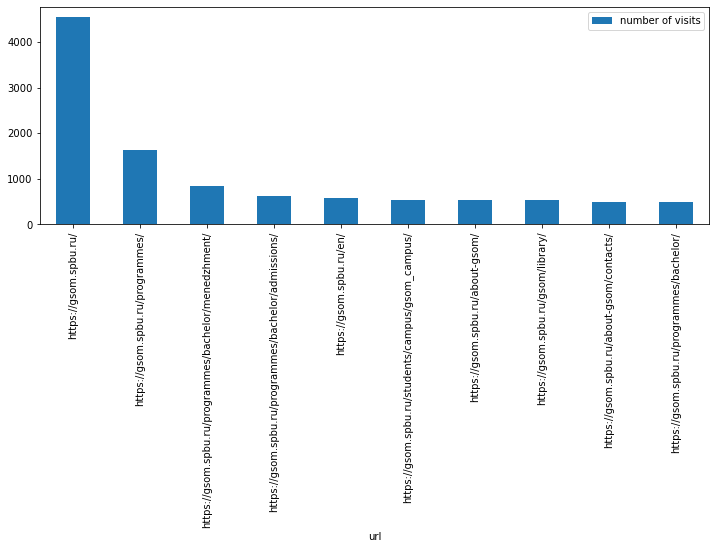

In [22]:
#a bar chart with pandas
#we need to transform the number of visits in an integer type
df['number of visits'] = df['number of visits'].astype('int64')
df[:10].plot(x="url",y="number of visits",kind="bar",figsize=(12,4))

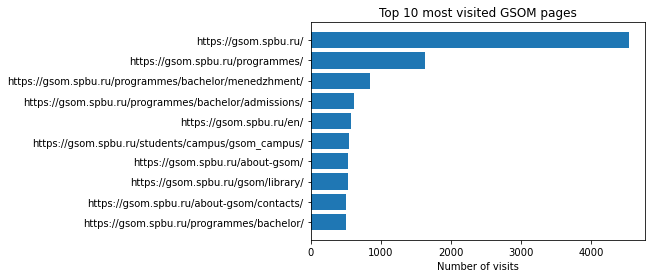

In [23]:
#a bar chart with matplotlib
import numpy as np
from matplotlib import pyplot as plt
#set property to build graphics inside jupyter
%matplotlib inline
df_rev=df[::-1]
plt.barh(df_rev["url"],df_rev["number of visits"])
plt.title("Top 10 most visited GSOM pages")
plt.xlabel("Number of visits")
plt.show()

In [24]:
# Q2
#Find out top 10 most popular pages on GSOM web sites for the last month
#my input
query = """SELECT ClientID,Date,URL,Title, FROM gsomlogs.hits_all 
WHERE Date BETWEEN Date(date_sub(Date(now()), INTERVAL 30 DAY)) and Date(now())"""
#Polina/Nikita input
query = """SELECT URL, COUNT(DISTINCT ClientID) AS ID_count FROM gsomlogs.hits_all
WHERE Date > DATE_SUB(NOW(), INTERVAL 30 DAY)
GROUP BY URL ORDER BY ID_count DESC"""

In [25]:
pd.set_option('display.max_colwidth', 1000)
data = get_data_short(query=query)
data = [x.split('\t') for x in data.split('\n')]
df = pd.DataFrame(data[0:10],columns=["url","number of visits"])
df.index=df.index+1
print(df)

request status code: 200
                                                      url number of visits
1                                   https://gsom.spbu.ru/             4544
2                        https://gsom.spbu.ru/programmes/             1634
3   https://gsom.spbu.ru/programmes/bachelor/menedzhment/              850
4    https://gsom.spbu.ru/programmes/bachelor/admissions/              620
5                                https://gsom.spbu.ru/en/              583
6       https://gsom.spbu.ru/students/campus/gsom_campus/              541
7                        https://gsom.spbu.ru/about-gsom/              530
8                      https://gsom.spbu.ru/gsom/library/              529
9               https://gsom.spbu.ru/about-gsom/contacts/              503
10              https://gsom.spbu.ru/programmes/bachelor/              500


In [26]:
#Q3
#Top pages for visitors interested in MiBA program for the last month 
query = """SELECT URL, COUNT(DISTINCT ClientID) AS ID_count FROM gsomlogs.hits_all
WHERE URL LIKE '%miba%' AND Date > DATE_SUB(NOW(), INTERVAL 30 DAY)
GROUP BY URL ORDER BY ID_count DESC"""
#can also cut the database in select already
query = """SELECT URL, COUNT(DISTINCT ClientID) AS ID_count 
FROM (SELECT * from gsomlogs.hits_all WHERE Date > DATE_SUB(NOW(), INTERVAL 30 DAY) 
AND URL LIKE '%miba%')
GROUP BY URL ORDER BY ID_count DESC"""

In [27]:
data = get_data_short(query=query)
data = [x.split('\t') for x in data.split('\n')]
df = pd.DataFrame(data)
df.head(10)

request status code: 200


,0,1
0,https://gsom.spbu.ru/programmes/graduate/miba/,171
1,https://gsom.spbu.ru/en/programmes/graduate/miba/,43
2,https://gsom.spbu.ru/images/cms/data/2011_03_17_future_petersburg/miba_internship.docx,7
3,https://gsom.spbu.ru/programmes/graduate/candidates/miba-admissions/,2
4,,None


In [28]:
query = """SELECT URL, COUNT(DISTINCT ClientID) AS ID_count 
FROM (SELECT * from gsomlogs.hits_all 
WHERE Date > DATE_SUB(NOW(), INTERVAL 10 DAY) 
AND Referer='')
GROUP BY URL ORDER BY ID_count DESC"""

In [29]:
data = get_data_short(query=query)
data = [x.split('\t') for x in data.split('\n')]
df = pd.DataFrame(data)
df.head(10)

request status code: 200


,0,1
0,https://gsom.spbu.ru/,300
1,https://gsom.spbu.ru/gsom/library/index/grebennikov/,93
2,https://gsom.spbu.ru/research/conferences/emc/,40
3,https://gsom.spbu.ru/en/research/conferences/emc/tracks-and-events/business-in-society/,32
4,https://gsom.spbu.ru/gsom/library/,28
5,https://gsom.spbu.ru/en/,28
6,https://gsom.spbu.ru/gsom/library/index/ibooks/,25
7,https://gsom.spbu.ru/gsom/library/index/financial_resources/,24
8,https://gsom.spbu.ru/en/research/conferences/emc/,22
9,https://gsom.spbu.ru/gsom/library/index/,21


In [38]:
#Why do I have to put 10 days to get the last 7 days?
#BECAUSE THIS SERVER COLLECTS DATA EVERY 2 DAYS FFS
query = """SELECT Date, COUNT(DISTINCT ClientID) AS ID_count 
FROM (SELECT * from gsomlogs.hits_all 
WHERE Date > DATE_SUB(NOW(), INTERVAL 10 DAY) 
AND Referer='')
GROUP BY Date ORDER BY ID_count DESC"""

In [39]:
data = get_data_short(query=query)
data = [x.split('\t') for x in data.split('\n')]
df = pd.DataFrame(data)
print(df)

request status code: 200
            0     1
0  2022-09-27   278
1  2022-09-28   261
2  2022-09-29   248
3  2022-09-30   191
4  2022-10-01   121
5  2022-09-24   105
6  2022-09-25    98
7              None
